In [39]:
#!pip install yfinance plotext PyPortfolioOpt

In [2]:
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

import gym
from gym.envs.registration import register
from gym import spaces
from gym.utils import seeding

from collections import deque
from time import time
from random import sample

import yfinance as yf
import talib
from sklearn.preprocessing import StandardScaler

import random
import time
import datetime
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection

import os
import pickle

### Loading the already trained trading agent

In [4]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size,
                 decay_steps
                ):
        
        self.state_dim = state_dim
        self.decay_steps = decay_steps
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True
        

    def load_ddqn(self, path):
        self.online_network = load_model(path)
        self.target_network = load_model(path)
        self.target_network.trainable = False

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        
        layers.append(tf.keras.layers.BatchNormalization(input_shape=(self.state_dim,)))
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
            layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(learning_rate=tf.keras.experimental.CosineDecay(initial_learning_rate=self.learning_rate, decay_steps=decay_steps)))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state,verbose=0)
        return np.argmax(q, axis=1).squeeze() 
    
    def greedy_policy(self, state):
        self.total_steps += 1
        q = self.online_network.predict(state,verbose=0)
        return np.argmax(q, axis=1).squeeze() 

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        
        q_values[tuple([self.idx, actions])] = targets
        

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()


def visualize(result):
    x = result.index.tolist()
    y = result['market_nav'].tolist()
    z = np.array(result['position'].tolist())


    cmap = ListedColormap(['r', 'y', 'g'])
    norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
    points = np.array([x, y]).T.reshape(-1, 1, 2)

    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(z)


    fig = plt.figure(figsize=(20, 10))
    plt.gca().add_collection(lc)
    #plt.xlim(min(x), max(x))
    #plt.ylim(min(y), max(y))

    plt.plot(result.index,result['nav'])
    plt.scatter(result.index[result["trade"]>0],result['market_nav'][result["trade"]>0]+0.002,c='g', marker="^", s=50)
    plt.scatter(result.index[result["trade"]<0],result['market_nav'][result["trade"]<0]-0.002,c='r', marker="v", s=50)
    plt.show()


    

In [5]:
trading_cost_bps = 0.001
time_cost_bps = 0

register(
    id='trading-v0',
    entry_point='trading_environment:TradingEnvironment',
    max_episode_steps=1225
)

In [6]:
feature_dict = {
    'core-set':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR'
    ],
    'news-set-1':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'count_news','count_opinions'
    ],
    'news-set-2':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_title_news_1', 'sent_title_news_5','sent_title_news_21'
    ]
    ,
    'news-set-3':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_title_opinions_1', 'sent_title_opinions_5','sent_title_opinions_21'
    ]
    ,
    'news-set-4':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_content_news_1', 'sent_content_news_5','sent_content_news_21'
    ]
    ,
    'news-set-5':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_content_opinions_1','sent_content_opinions_5', 'sent_content_opinions_21'
    ]
    ,
    'news-set-6':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'count_news','count_opinions',
        'sent_title_news_1', 'sent_title_news_5','sent_title_news_21',
        'sent_title_opinions_1', 'sent_title_opinions_5','sent_title_opinions_21',
        'sent_content_news_1', 'sent_content_news_5','sent_content_news_21',
        'sent_content_opinions_1','sent_content_opinions_5', 'sent_content_opinions_21'
    ],
    'twitter-set-1':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'tweetCount_cashtags','retweetCount_cashtags','tweetCount_keywords','retweetCount_keywords'
    ],
    'twitter-set-2':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_tweeteval_cashtags_1', 'sent_tweeteval_cashtags_5','sent_tweeteval_cashtags_21'
        
    ],
    'twitter-set-3':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'sent_tweeteval_keywords_1','sent_tweeteval_keywords_5', 'sent_tweeteval_keywords_21',
    ],
    'twitter-set-4':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'tweetCount_cashtags','retweetCount_cashtags','tweetCount_keywords','retweetCount_keywords',
        'sent_tweeteval_cashtags_1', 'sent_tweeteval_cashtags_5','sent_tweeteval_cashtags_21',
        'sent_tweeteval_keywords_1','sent_tweeteval_keywords_5', 'sent_tweeteval_keywords_21',
    ],
    'full-set':[
        'returns_1', 'returns_2', 'returns_5', 'returns_10', 'returns_21','STOCH', 'ULTOSC', 'RSI', 'MACD', 'ATR',
        'count_news','count_opinions',
        'sent_title_news_1', 'sent_title_news_5','sent_title_news_21',
        'sent_title_opinions_1', 'sent_title_opinions_5','sent_title_opinions_21',
        'sent_content_news_1', 'sent_content_news_5','sent_content_news_21',
        'sent_content_opinions_1','sent_content_opinions_5', 'sent_content_opinions_21',
        'tweetCount_cashtags','retweetCount_cashtags','tweetCount_keywords','retweetCount_keywords',
        'sent_tweeteval_cashtags_1', 'sent_tweeteval_cashtags_5','sent_tweeteval_cashtags_21',
        'sent_tweeteval_keywords_1','sent_tweeteval_keywords_5', 'sent_tweeteval_keywords_21'
        
    ]

}

### Calculating the trading performance

In [61]:
## redundant
max_episodes = 300
gamma = .95
tau = 10000
architecture = (256,128) 
learning_rate = 0.0001
l2_reg = 1e-6 
replay_capacity = 1000000
batch_size = 200
epsilon_start = 1
epsilon_end = .1
epsilon_decay_steps = 1500
epsilon_exponential_decay = 1
decay_steps = 0
num_actions = 3
#########



tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "BRK-A", "TSM", "NVDA", "JPM", "GME"] 
feature_sets = ['core-set', 'news-set-1', 'news-set-2', 'news-set-3', 'news-set-4', 'news-set-5', 'news-set-6', 'twitter-set-1', 'twitter-set-2', 'twitter-set-3', 'twitter-set-4', 'full-set'] #,

results = pd.DataFrame()

for feature_set in feature_sets:

    features = feature_dict[feature_set]
    state_dim = len(features)

    for ticker in tickers:        
        ddqn = DDQNAgent(state_dim=state_dim,
                num_actions=num_actions,
                learning_rate=learning_rate,
                gamma=gamma,
                epsilon_start=epsilon_start,
                epsilon_end=epsilon_end,
                epsilon_decay_steps=epsilon_decay_steps,
                epsilon_exponential_decay=epsilon_exponential_decay,
                replay_capacity=replay_capacity,
                architecture=architecture,
                l2_reg=l2_reg,
                tau=tau,
                batch_size=batch_size,
                decay_steps=decay_steps)
        
        path = "logs/merged_logs/models/" + ticker + "/" + feature_set + ".h5"
        ddqn.load_ddqn(path)
    
        print(feature_set + " - " + ticker)
        for data_type in ['train','dev','test']:
            lens = {'train':1225,'dev':252,'test':333}
            trading_environment = gym.make(
                'trading-v0',
                ticker=ticker,
                trading_days=lens[data_type],
                trading_cost_bps=trading_cost_bps,
                time_cost_bps=time_cost_bps,
                data_path=f'../data-prep/features/data_{data_type}.csv',
                features=features)

            this_state = trading_environment.reset()
            for episode_step in range(trading_environment.spec.max_episode_steps):
                action = ddqn.greedy_policy(this_state.reshape(-1, state_dim))
                next_state, reward, done, _ = trading_environment.step(action)
                if done:
                    break
                this_state = next_state

            result = trading_environment.env.simulator.result()


            result["day"] = result.index 
            result["ticker"] = ticker
            result["feature_set"] = feature_set
            result["data_type"] = data_type
            result["date"] = trading_environment.data_source.dates[1:]
            results = pd.concat([results,result])

core-set - AAPL
core-set - MSFT
core-set - GOOGL
core-set - AMZN
core-set - FB
core-set - TSLA
core-set - BRK-A
core-set - TSM
core-set - NVDA
core-set - JPM
core-set - GME
news-set-1 - AAPL
news-set-1 - MSFT
news-set-1 - GOOGL
news-set-1 - AMZN
news-set-1 - FB
news-set-1 - TSLA
news-set-1 - BRK-A
news-set-1 - TSM
news-set-1 - NVDA
news-set-1 - JPM
news-set-1 - GME
news-set-2 - AAPL
news-set-2 - MSFT
news-set-2 - GOOGL
news-set-2 - AMZN
news-set-2 - FB
news-set-2 - TSLA
news-set-2 - BRK-A
news-set-2 - TSM
news-set-2 - NVDA
news-set-2 - JPM
news-set-2 - GME
news-set-3 - AAPL
news-set-3 - MSFT
news-set-3 - GOOGL
news-set-3 - AMZN
news-set-3 - FB
news-set-3 - TSLA
news-set-3 - BRK-A
news-set-3 - TSM
news-set-3 - NVDA
news-set-3 - JPM
news-set-3 - GME
news-set-4 - AAPL
news-set-4 - MSFT
news-set-4 - GOOGL
news-set-4 - AMZN
news-set-4 - FB
news-set-4 - TSLA
news-set-4 - BRK-A
news-set-4 - TSM
news-set-4 - NVDA
news-set-4 - JPM
news-set-4 - GME
news-set-5 - AAPL
news-set-5 - MSFT
news-set-5 

### Calculating the DCA performance

In [66]:
#results.to_csv("results.csv")

In [67]:
results = pd.read_csv("results.csv", index_col=0)
#results["date"] = results["date.1"]
results["date"] = pd.to_datetime(results["date"])
results.index = results["date"]

results["contribute_first"] = (results["date"] == results.groupby(["ticker","feature_set","data_type",results["date"].dt.year, results["date"].dt.month])["date"].transform("min")).astype(int)
results["contribute_last"] = (results["date"] == results.groupby(["ticker","feature_set","data_type",results["date"].dt.year, results["date"].dt.month])["date"].transform("max")).astype(int)

results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
#results = results.drop("date", 1)

In [68]:
results.loc[results["date"] == results.groupby(["ticker","feature_set","data_type","year","month"])["date"].transform("max"),"action"] = 2

In [69]:
results

action       nav  market_nav  market_return  strategy_return  \
date                                                                       
2015-02-20     2.0  1.000000    1.000000       0.008174        -0.001000   
2015-02-23     2.0  1.027027    1.027027       0.027027         0.027027   
2015-02-24     2.0  1.020618    1.020618      -0.006241        -0.006241   
2015-02-25     2.0  0.994517    0.994517      -0.025573        -0.025573   
2015-02-26     0.0  1.005115    1.007104       0.012656         0.010656   
...            ...       ...         ...            ...              ...   
2022-04-25     1.0  8.387405    7.826712      -0.016423        -0.000000   
2022-04-26     2.0  8.379017    7.345998      -0.061420        -0.001000   
2022-04-27     1.0  8.517730    7.474956       0.017555         0.016555   
2022-04-28     1.0  8.517730    7.444444      -0.004082        -0.000000   
2022-04-29     2.0  8.517730    7.200345      -0.032789        -0.000000   

            position   cost  trade  day ticker feature_set data_type  \
date                                                                   
2015-02-20       1.0  0.001    1.0    0   AAPL    core-set     train   
2015-02-23       1.0  0.000    0.0    1   AAPL    core-set     train   
2015-02-24       1.0  0.000    0.0    2   AAPL    core-set     train   
2015-02-25       1.0  0.000    0.0    3   AAPL    core-set     train   
2015-02-26      -1.0  0.002   -2.0    4   AAPL    core-set     train   
...              ...    ...    ...  ...    ...         ...       ...   
2022-04-25       0.0  0.000    0.0  328    GME    full-set      test   
2022-04-26       1.0  0.001    1.0  329    GME    full-set      test   
2022-04-27       0.0  0.001   -1.0  330    GME    full-set      test   
2022-04-28       0.0  0.000    0.0  331    GME    full-set      test   
2022-04-29       0.0  0.000    0.0  332    GME    full-set      test   

                 date  contribute_first  contribute_last  year  month  
date                                                                   
2015-02-20 2015-02-20                 1                0  2015      2  
2015-02-23 2015-02-23                 0                0  2015      2  
2015-02-24 2015-02-24                 0                0  2015      2  
2015-02-25 2015-02-25                 0                0  2015      2  
2015-02-26 2015-02-26                 0                0  2015      2  
...               ...               ...              ...   ...    ...  
2022-04-25 2022-04-25                 0                0  2022      4  
2022-04-26 2022-04-26                 0                0  2022      4  
2022-04-27 2022-04-27                 0                0  2022      4  
2022-04-28 2022-04-28                 0                0  2022      4  
2022-04-29 2022-04-29                 0                1  2022      4  

[238920 rows x 17 columns]

In [70]:
s = pd.DataFrame(results[results["action"]==2].groupby(["ticker","feature_set","data_type","year","month"])["date"].agg("min")).reset_index()
s = s.rename({
    "date":"timed_date"}, axis='columns')
s

ticker    feature_set data_type  year  month timed_date
0       AAPL       core-set       dev  2020      1 2020-01-07
1       AAPL       core-set       dev  2020      2 2020-02-03
2       AAPL       core-set       dev  2020      3 2020-03-02
3       AAPL       core-set       dev  2020      4 2020-04-06
4       AAPL       core-set       dev  2020      5 2020-05-15
...      ...            ...       ...   ...    ...        ...
11479    TSM  twitter-set-4     train  2019      8 2019-08-30
11480    TSM  twitter-set-4     train  2019      9 2019-09-30
11481    TSM  twitter-set-4     train  2019     10 2019-10-31
11482    TSM  twitter-set-4     train  2019     11 2019-11-29
11483    TSM  twitter-set-4     train  2019     12 2019-12-31

[11484 rows x 6 columns]

In [71]:
results = pd.merge(results, s, how="left", on = ["ticker","feature_set","data_type","year","month"])

In [72]:
results["contribute_timed"] = (results["date"] == results["timed_date"]).astype(int)

In [73]:
results

action       nav  market_nav  market_return  strategy_return  \
0          2.0  1.000000    1.000000       0.008174        -0.001000   
1          2.0  1.027027    1.027027       0.027027         0.027027   
2          2.0  1.020618    1.020618      -0.006241        -0.006241   
3          2.0  0.994517    0.994517      -0.025573        -0.025573   
4          0.0  1.005115    1.007104       0.012656         0.010656   
...        ...       ...         ...            ...              ...   
238915     1.0  8.387405    7.826712      -0.016423        -0.000000   
238916     2.0  8.379017    7.345998      -0.061420        -0.001000   
238917     1.0  8.517730    7.474956       0.017555         0.016555   
238918     1.0  8.517730    7.444444      -0.004082        -0.000000   
238919     2.0  8.517730    7.200345      -0.032789        -0.000000   

        position   cost  trade  day ticker feature_set data_type       date  \
0            1.0  0.001    1.0    0   AAPL    core-set     train 2015-02-20   
1            1.0  0.000    0.0    1   AAPL    core-set     train 2015-02-23   
2            1.0  0.000    0.0    2   AAPL    core-set     train 2015-02-24   
3            1.0  0.000    0.0    3   AAPL    core-set     train 2015-02-25   
4           -1.0  0.002   -2.0    4   AAPL    core-set     train 2015-02-26   
...          ...    ...    ...  ...    ...         ...       ...        ...   
238915       0.0  0.000    0.0  328    GME    full-set      test 2022-04-25   
238916       1.0  0.001    1.0  329    GME    full-set      test 2022-04-26   
238917       0.0  0.001   -1.0  330    GME    full-set      test 2022-04-27   
238918       0.0  0.000    0.0  331    GME    full-set      test 2022-04-28   
238919       0.0  0.000    0.0  332    GME    full-set      test 2022-04-29   

        contribute_first  contribute_last  year  month timed_date  \
0                      1                0  2015      2 2015-02-20   
1                      0                0  2015      2 2015-02-20   
2                      0                0  2015      2 2015-02-20   
3                      0                0  2015      2 2015-02-20   
4                      0                0  2015      2 2015-02-20   
...                  ...              ...   ...    ...        ...   
238915                 0                0  2022      4 2022-04-01   
238916                 0                0  2022      4 2022-04-01   
238917                 0                0  2022      4 2022-04-01   
238918                 0                0  2022      4 2022-04-01   
238919                 0                1  2022      4 2022-04-01   

        contribute_timed  
0                      1  
1                      0  
2                      0  
3                      0  
4                      0  
...                  ...  
238915                 0  
238916                 0  
238917                 0  
238918                 0  
238919                 0  

[238920 rows x 19 columns]

In [74]:
pd.options.mode.chained_assignment = None

eval = pd.DataFrame()

results.index = results["date"]

costs = 0.001

for name, group in results.groupby(["ticker","feature_set","data_type"]):
  group["t"] = group["contribute_first"].sum()
  group["tt"] =  group["contribute_timed"].sum()
  group["contribution_first"] = (group["contribute_first"] / group["contribute_first"].sum())  * (1-costs)
  group["contribution_last"] = (group["contribute_last"] / group["contribute_last"].sum())  * (1-costs)
  group["contribution_timed"] = (group["contribute_timed"] / group["contribute_timed"].sum()) * (1-costs)
  group["nav_buy_and_hold"] = 0
  group["nav_daily_trade"] = 0
  group["nav_dca_first"] = 0
  group["nav_dca_last"] = 0 
  group["nav_dca_timed"] = 0

  for i in range(group.shape[0]):
    if i == 0:
      nav_buy_and_hold = 1 
      nav_daily_trade = 1
      nav_dca_first = group["contribution_first"][i]
      nav_dca_last = group["contribution_last"][i]
      nav_dca_timed = group["contribution_timed"][i]
    else:
      nav_buy_and_hold = nav_buy_and_hold * (1 + group["market_return"][i])
      nav_daily_trade = nav_daily_trade * (1 + group["strategy_return"][i])
      nav_dca_first = (nav_dca_first) * (1 + group["market_return"][i]) + group["contribution_first"][i]
      nav_dca_last = (nav_dca_last) * (1 + group["market_return"][i]) + group["contribution_last"][i]
      nav_dca_timed = (nav_dca_timed) * (1 + group["market_return"][i]) + group["contribution_timed"][i]

    group["nav_buy_and_hold"].iloc[i] = nav_buy_and_hold
    group["nav_daily_trade"].iloc[i] = nav_daily_trade
    group["nav_dca_first"].iloc[i] = nav_dca_first
    group["nav_dca_last"].iloc[i] = nav_dca_last
    group["nav_dca_timed"].iloc[i] = nav_dca_timed
    

    
  eval = pd.concat([eval,group])

    

In [75]:


def visualize(result,cols):
    result=result.reset_index(drop=True)
    x = result.index.tolist()
    y = result[cols[0]].tolist()
    z = np.array(result['position'].tolist())


    cmap = ListedColormap(['r', 'y', 'g'])
    norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
    points = np.array([x, y]).T.reshape(-1, 1, 2)

    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(z)


    fig = plt.figure(figsize=(20, 10))
    plt.gca().add_collection(lc)
    #plt.xlim(min(x), max(x))
    #plt.ylim(min(y), max(y))

    plt.plot(result.index,result[cols[1]])
    plt.plot(result.index,result[cols[2]])
    plt.plot(result.index,result[cols[3]])
    plt.plot(result.index,result[cols[4]])
    plt.scatter(result.index[result["trade"]>0],result[cols[0]][result["trade"]>0]+0.002,c='g', marker="^", s=50)
    plt.scatter(result.index[result["trade"]<0],result[cols[0]][result["trade"]<0]-0.002,c='r', marker="v", s=50)
    plt.show()

    # plt.scatter(result.index[result["trade"]>0],result[cols[0]][result["trade"]>0]+0.002,c='g', marker="^", s=50)
    # plt.scatter(result.index[result["trade"]<0],result[cols[0]][result["trade"]<0]-0.002,c='r', marker="v", s=50)

In [76]:
# for name, group in eval.groupby(["ticker","feature_set","data_type"]):
#   print(name)
#   visualize(group,cols = ['nav_buy_and_hold','nav_daily_trade','nav_dca','nav_dca_timed'])

In [77]:
eval

action       nav  market_nav  market_return  strategy_return  \
date                                                                       
2020-01-03     0.0  1.000000    1.000000      -0.009722        -0.001000   
2020-01-06     0.0  0.992032    1.007968       0.007968        -0.007968   
2020-01-07     2.0  0.994713    1.003228      -0.004703         0.002703   
2020-01-08     2.0  1.010715    1.019366       0.016086         0.016086   
2020-01-09     2.0  1.032183    1.041018       0.021241         0.021241   
...            ...       ...         ...            ...              ...   
2019-12-24     1.0  1.041949    2.363339      -0.007901        -0.000000   
2019-12-26     1.0  1.041949    2.383388       0.008483         0.000000   
2019-12-27     1.0  1.041949    2.391980       0.003605         0.000000   
2019-12-30     1.0  1.041949    2.367021      -0.010434        -0.000000   
2019-12-31     2.0  1.041949    2.377250       0.004322         0.000000   

            position   cost  trade   day ticker  ...   t  tt  \
date                                             ...           
2020-01-03      -1.0  0.001   -1.0     0   AAPL  ...  12  12   
2020-01-06      -1.0  0.000    0.0     1   AAPL  ...  12  12   
2020-01-07       1.0  0.002    2.0     2   AAPL  ...  12  12   
2020-01-08       1.0  0.000    0.0     3   AAPL  ...  12  12   
2020-01-09       1.0  0.000    0.0     4   AAPL  ...  12  12   
...              ...    ...    ...   ...    ...  ...  ..  ..   
2019-12-24       0.0  0.000    0.0  1220    TSM  ...  59  59   
2019-12-26       0.0  0.000    0.0  1221    TSM  ...  59  59   
2019-12-27       0.0  0.000    0.0  1222    TSM  ...  59  59   
2019-12-30       0.0  0.000    0.0  1223    TSM  ...  59  59   
2019-12-31       0.0  0.000    0.0  1224    TSM  ...  59  59   

           contribution_first  contribution_last  contribution_timed  \
date                                                                   
2020-01-03            0.08325           0.000000            0.000000   
2020-01-06            0.00000           0.000000            0.000000   
2020-01-07            0.00000           0.000000            0.083250   
2020-01-08            0.00000           0.000000            0.000000   
2020-01-09            0.00000           0.000000            0.000000   
...                       ...                ...                 ...   
2019-12-24            0.00000           0.000000            0.000000   
2019-12-26            0.00000           0.000000            0.000000   
2019-12-27            0.00000           0.000000            0.000000   
2019-12-30            0.00000           0.000000            0.000000   
2019-12-31            0.00000           0.016932            0.016932   

            nav_buy_and_hold  nav_daily_trade nav_dca_first  nav_dca_last  \
date                                                                        
2020-01-03          1.000000         1.000000      0.083250      0.000000   
2020-01-06          1.007968         0.992032      0.083913      0.000000   
2020-01-07          1.003228         0.994713      0.083519      0.000000   
2020-01-08          1.019366         1.010715      0.084862      0.000000   
2020-01-09          1.041018         1.032183      0.086665      0.000000   
...                      ...              ...           ...           ...   
2019-12-24          2.363339         1.041949      1.821186      1.788788   
2019-12-26          2.383388         1.041949      1.836636      1.803963   
2019-12-27          2.391980         1.041949      1.843257      1.810467   
2019-12-30          2.367021         1.041949      1.824024      1.791576   
2019-12-31          2.377250         1.041949      1.831906      1.816250   

            nav_dca_timed  
date                       
2020-01-03       0.000000  
2020-01-06       0.000000  
2020-01-07       0.083250  
2020-01-08       0.084589  
2020-01-09       0.086386  
...                   ...  
2019-12-24       1.791330  

### Calculating equally-weighted portfolio performance

In [78]:
eval["equal_w"] = 1/11

In [79]:
eval["nav_buy_and_hold_equal_w"] = eval["nav_buy_and_hold"] * eval["equal_w"]
eval["nav_daily_trade_equal_w"] = eval["nav_daily_trade"] * eval["equal_w"]
eval["nav_dca_first_equal_w"] = eval["nav_dca_first"] * eval["equal_w"]
eval["nav_dca_last_equal_w"] = eval["nav_dca_last"] * eval["equal_w"]
eval["nav_dca_timed_equal_w"] = eval["nav_dca_timed"] * eval["equal_w"]



### Calculating min-var portfolio performance

In [80]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "BRK-A", "TSM", "NVDA", "JPM", "GME"] 
prices = yf.download(tickers, start="2015-01-01", end="2019-12-31")["Adj Close"]
prices

[*********************100%***********************]  11 of 11 completed


AAPL       AMZN     BRK-A       GME  \
Date                                                                  
2015-01-02 00:00:00-05:00  24.644011  15.426000  223600.0  6.288958   
2015-01-05 00:00:00-05:00  23.949757  15.109500  220980.0  6.460138   
2015-01-06 00:00:00-05:00  23.952009  14.764500  220450.0  6.268492   
2015-01-07 00:00:00-05:00  24.287870  14.921000  223480.0  6.195927   
2015-01-08 00:00:00-05:00  25.221066  15.023000  226680.0  6.268492   
...                              ...        ...       ...       ...   
2019-12-23 00:00:00-05:00  69.672493  89.650002  338045.0  1.402500   
2019-12-24 00:00:00-05:00  69.738724  89.460503  338390.0  1.360000   
2019-12-26 00:00:00-05:00  71.122375  93.438499  339650.0  1.350000   
2019-12-27 00:00:00-05:00  71.095375  93.489998  338920.0  1.475000   
2019-12-30 00:00:00-05:00  71.517334  92.344498  338750.0  1.532500   

                               GOOGL         JPM        META        MSFT  \
Date                                                                       
2015-01-02 00:00:00-05:00  26.477501   50.305367   78.449997   40.926445   
2015-01-05 00:00:00-05:00  25.973000   48.743637   77.190002   40.550095   
2015-01-06 00:00:00-05:00  25.332001   47.479767   76.150002   39.954918   
2015-01-07 00:00:00-05:00  25.257500   47.552219   76.150002   40.462570   
2015-01-08 00:00:00-05:00  25.345501   48.614830   78.180000   41.652897   
...                              ...         ...         ...         ...   
2019-12-23 00:00:00-05:00  67.531502  125.197365  206.179993  153.462509   
2019-12-24 00:00:00-05:00  67.221497  125.544106  205.119995  153.433289   
2019-12-26 00:00:00-05:00  68.123497  126.876381  207.789993  154.690903   
2019-12-27 00:00:00-05:00  67.732002  126.967651  208.100006  154.973648   
2019-12-30 00:00:00-05:00  66.985497  126.502235  204.410004  153.638000   

                                NVDA       TSLA        TSM  
Date                                                        
2015-01-02 00:00:00-05:00   4.836186  14.620667  17.525560  
2015-01-05 00:00:00-05:00   4.754501  14.006000  17.100800  
2015-01-06 00:00:00-05:00   4.610355  14.085333  16.801889  
2015-01-07 00:00:00-05:00   4.598341  14.063333  17.045736  
2015-01-08 00:00:00-05:00   4.771318  14.041333  17.155861  
...                              ...        ...        ...  
2019-12-23 00:00:00-05:00  59.514214  27.948000  54.951843  
2019-12-24 00:00:00-05:00  59.464378  28.350000  54.517666  
2019-12-26 00:00:00-05:00  59.606422  28.729334  54.980160  
2019-12-27 00:00:00-05:00  59.028271  28.691999  55.178371  
2019-12-30 00:00:00-05:00  57.894409  27.646667  54.602608  

[1257 rows x 11 columns]

In [81]:
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

AAPL      AMZN     BRK-A       GME     GOOGL       JPM      META  \
AAPL   0.061731  0.035811  0.018017  0.022233  0.030752  0.022537  0.032271   
AMZN   0.035811  0.085625  0.016443  0.021814  0.044622  0.021597  0.047034   
BRK-A  0.018017  0.016443  0.025703  0.016857  0.016583  0.024014  0.014452   
GME    0.022233  0.021814  0.016857  0.224996  0.019677  0.024723  0.016698   
GOOGL  0.030752  0.044622  0.016583  0.019677  0.056574  0.020561  0.040750   
JPM    0.022537  0.021597  0.024014  0.024723  0.020561  0.044149  0.019873   
META   0.032271  0.047034  0.014452  0.016698  0.040750  0.019873  0.079692   
MSFT   0.033233  0.042710  0.019378  0.016896  0.036202  0.023806  0.033914   
NVDA   0.045631  0.049650  0.023348  0.036224  0.042000  0.031187  0.044960   
TSLA   0.033282  0.040961  0.017261  0.022271  0.031375  0.022934  0.037236   
TSM    0.029843  0.026047  0.015356  0.020941  0.024892  0.018803  0.022410   

           MSFT      NVDA      TSLA       TSM  
AAPL   0.033233  0.045631  0.033282  0.029843  
AMZN   0.042710  0.049650  0.040961  0.026047  
BRK-A  0.019378  0.023348  0.017261  0.015356  
GME    0.016896  0.036224  0.022271  0.020941  
GOOGL  0.036202  0.042000  0.031375  0.024892  
JPM    0.023806  0.031187  0.022934  0.018803  
META   0.033914  0.044960  0.037236  0.022410  
MSFT   0.054393  0.046720  0.032642  0.027369  
NVDA   0.046720  0.182617  0.053444  0.047221  
TSLA   0.032642  0.053444  0.202141  0.030442  
TSM    0.027369  0.047221  0.030442  0.056752

<AxesSubplot:>

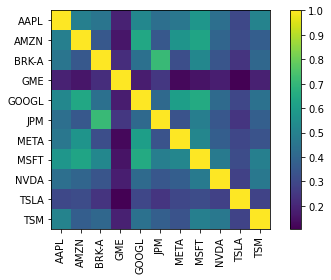

In [82]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

In [83]:
from pypfopt import EfficientFrontier

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(None, S, weight_bounds=(0, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.0306),
             ('AMZN', 0.00498),
             ('BRK-A', 0.61229),
             ('GME', 0.02549),
             ('GOOGL', 0.07385),
             ('JPM', 0.03561),
             ('META', 0.07276),
             ('MSFT', 0.0),
             ('NVDA', 0.0),
             ('TSLA', 0.00508),
             ('TSM', 0.13935)])

In [84]:
minvar_weights = pd.DataFrame({"minvar_w":weights})

minvar_weights.T[tickers]

AAPL  MSFT    GOOGL     AMZN     META     TSLA    BRK-A      TSM  \
minvar_w  0.0306   0.0  0.07385  0.00498  0.07276  0.00508  0.61229  0.13935   

          NVDA      JPM      GME  
minvar_w   0.0  0.03561  0.02549

In [85]:
minvar_weights = minvar_weights.reset_index().rename({"index":"ticker"},axis=1)

In [86]:
eval = eval.merge(minvar_weights, how="left", on="ticker", validate="m:1")
eval.index = eval["date"]

eval["nav_buy_and_hold_minvar_w"] = eval["nav_buy_and_hold"] * eval["minvar_w"]
eval["nav_daily_trade_minvar_w"] = eval["nav_daily_trade"] * eval["minvar_w"]
eval["nav_dca_first_minvar_w"] = eval["nav_dca_first"] * eval["minvar_w"]
eval["nav_dca_last_minvar_w"] = eval["nav_dca_last"] * eval["minvar_w"]
eval["nav_dca_timed_minvar_w"] = eval["nav_dca_timed"] * eval["minvar_w"]

eval 

action       nav  market_nav  market_return  strategy_return  \
date                                                                       
2020-01-03     0.0  1.000000    1.000000      -0.009722        -0.001000   
2020-01-06     0.0  0.992032    1.007968       0.007968        -0.007968   
2020-01-07     2.0  0.994713    1.003228      -0.004703         0.002703   
2020-01-08     2.0  1.010715    1.019366       0.016086         0.016086   
2020-01-09     2.0  1.032183    1.041018       0.021241         0.021241   
...            ...       ...         ...            ...              ...   
2019-12-24     1.0  1.041949    2.363339      -0.007901        -0.000000   
2019-12-26     1.0  1.041949    2.383388       0.008483         0.000000   
2019-12-27     1.0  1.041949    2.391980       0.003605         0.000000   
2019-12-30     1.0  1.041949    2.367021      -0.010434        -0.000000   
2019-12-31     2.0  1.041949    2.377250       0.004322         0.000000   

            position   cost  trade   day ticker  ... nav_daily_trade_equal_w  \
date                                             ...                           
2020-01-03      -1.0  0.001   -1.0     0   AAPL  ...                0.090909   
2020-01-06      -1.0  0.000    0.0     1   AAPL  ...                0.090185   
2020-01-07       1.0  0.002    2.0     2   AAPL  ...                0.090428   
2020-01-08       1.0  0.000    0.0     3   AAPL  ...                0.091883   
2020-01-09       1.0  0.000    0.0     4   AAPL  ...                0.093835   
...              ...    ...    ...   ...    ...  ...                     ...   
2019-12-24       0.0  0.000    0.0  1220    TSM  ...                0.094723   
2019-12-26       0.0  0.000    0.0  1221    TSM  ...                0.094723   
2019-12-27       0.0  0.000    0.0  1222    TSM  ...                0.094723   
2019-12-30       0.0  0.000    0.0  1223    TSM  ...                0.094723   
2019-12-31       0.0  0.000    0.0  1224    TSM  ...                0.094723   

           nav_dca_first_equal_w nav_dca_last_equal_w  nav_dca_timed_equal_w  \
date                                                                           
2020-01-03              0.007568             0.000000               0.000000   
2020-01-06              0.007628             0.000000               0.000000   
2020-01-07              0.007593             0.000000               0.007568   
2020-01-08              0.007715             0.000000               0.007690   
2020-01-09              0.007879             0.000000               0.007853   
...                          ...                  ...                    ...   
2019-12-24              0.165562             0.162617               0.162848   
2019-12-26              0.166967             0.163997               0.164230   
2019-12-27              0.167569             0.164588               0.164822   
2019-12-30              0.165820             0.162871               0.163102   
2019-12-31              0.166537             0.165114               0.165346   

            minvar_w  nav_buy_and_hold_minvar_w  nav_daily_trade_minvar_w  \
date                                                                        
2020-01-03   0.03060                   0.030600                  0.030600   
2020-01-06   0.03060                   0.030844                  0.030356   
2020-01-07   0.03060                   0.030699                  0.030438   
2020-01-08   0.03060                   0.031193                  0.030928   
2020-01-09   0.03060                   0.031855                  0.031585   
...              ...                        ...                       ...   
2019-12-24   0.13935                   0.329331                  0.145196   
2019-12-26   0.13935                   0.332125                  0.145196   
2019-12-27   0.13935                   0.333322                  0.145196   
2019-12-30   0.13935                   0.329844                  0.145196   
2019-12-31   0.13

### Evaluating portfolio's NAV

In [87]:
strategies = eval.groupby([eval.index,"feature_set","data_type"])[[
    "nav_buy_and_hold_equal_w","nav_daily_trade_equal_w","nav_dca_first_equal_w","nav_dca_last_equal_w","nav_dca_timed_equal_w",
    "nav_buy_and_hold_minvar_w","nav_daily_trade_minvar_w","nav_dca_first_minvar_w","nav_dca_last_minvar_w","nav_dca_timed_minvar_w",
]].agg("sum")
strategies['position'] = 0
strategies['trade'] = 0

In [88]:
strategies = strategies.reset_index()

In [89]:
strategies

date    feature_set data_type  nav_buy_and_hold_equal_w  \
0     2015-02-20       core-set     train                  1.000000   
1     2015-02-20       full-set     train                  1.000000   
2     2015-02-20     news-set-1     train                  1.000000   
3     2015-02-20     news-set-2     train                  1.000000   
4     2015-02-20     news-set-3     train                  1.000000   
...          ...            ...       ...                       ...   
21715 2022-04-29     news-set-6      test                  1.660007   
21716 2022-04-29  twitter-set-1      test                  1.660007   
21717 2022-04-29  twitter-set-2      test                  1.660007   
21718 2022-04-29  twitter-set-3      test                  1.660007   
21719 2022-04-29  twitter-set-4      test                  1.660007   

       nav_daily_trade_equal_w  nav_dca_first_equal_w  nav_dca_last_equal_w  \
0                     1.000000               0.016932              0.000000   
1                     1.000000               0.016932              0.000000   
2                     1.000000               0.016932              0.000000   
3                     1.000000               0.016932              0.000000   
4                     1.000000               0.016932              0.000000   
...                        ...                    ...                   ...   
21715                 0.963471               0.944619              0.908949   
21716                 0.762252               0.944619              0.908949   
21717                 0.923043               0.944619              0.908949   
21718                 0.906476               0.944619              0.908949   
21719                 1.529228               0.944619              0.908949   

       nav_dca_timed_equal_w  nav_buy_and_hold_minvar_w  \
0                   0.012314                   1.000010   
1                   0.007696                   1.000010   
2                   0.009236                   1.000010   
3                   0.012314                   1.000010   
4                   0.007696                   1.000010   
...                      ...                        ...   
21715               0.927669                   1.397153   
21716               0.938556                   1.397153   
21717               0.947096                   1.397153   
21718               0.942410                   1.397153   
21719               0.944998                   1.397153   

       nav_daily_trade_minvar_w  nav_dca_first_minvar_w  \
0                      1.000010                0.016932   
1                      1.000010                0.016932   
2                      1.000010                0.016932   
3                      1.000010                0.016932   
4                      1.000010                0.016932   
...                         ...                     ...   
21715                  0.777715                1.035662   
21716                  0.955142                1.035662   
21717                  1.087673                1.035662   
21718                  0.902230                1.035662   
21719                  1.337679                1.035662   

       nav_dca_last_minvar_w  nav_dca_timed_minvar_w  position  trade  
0                   0.000000                0.013538         0      0  
1                   0.000000                0.001639         0      0  
2                   0.000000                0.002005         0      0  
3                   0.000000                0.006047         0      0  
4                   0.000000                0.012306         0      0  
...                      ...                     ...       ...    ...  
21715               1.017413                1.027014         0      0  
21716               1.017413                1.026852         0      0  
21717               1.017413                1.034480         0      0  
21718               1.017413                1.026623         0      0  


In [90]:
strategies[strategies["date"].isin(["2019-12-31","2020-12-31","2022-04-29"])]

date    feature_set data_type  nav_buy_and_hold_equal_w  \
14688 2019-12-31       core-set     train                  3.142960   
14689 2019-12-31       full-set     train                  3.142960   
14690 2019-12-31     news-set-1     train                  3.142960   
14691 2019-12-31     news-set-2     train                  3.142960   
14692 2019-12-31     news-set-3     train                  3.142960   
14693 2019-12-31     news-set-4     train                  3.142960   
14694 2019-12-31     news-set-5     train                  3.142960   
14695 2019-12-31     news-set-6     train                  3.142960   
14696 2019-12-31  twitter-set-1     train                  3.142960   
14697 2019-12-31  twitter-set-2     train                  3.142960   
14698 2019-12-31  twitter-set-3     train                  3.142960   
14699 2019-12-31  twitter-set-4     train                  3.142960   
17712 2020-12-31       core-set       dev                  2.247531   
17713 2020-12-31       full-set       dev                  2.247531   
17714 2020-12-31     news-set-1       dev                  2.247531   
17715 2020-12-31     news-set-2       dev                  2.247531   
17716 2020-12-31     news-set-3       dev                  2.247531   
17717 2020-12-31     news-set-4       dev                  2.247531   
17718 2020-12-31     news-set-5       dev                  2.247531   
17719 2020-12-31     news-set-6       dev                  2.247531   
17720 2020-12-31  twitter-set-1       dev                  2.247531   
17721 2020-12-31  twitter-set-2       dev                  2.247531   
17722 2020-12-31  twitter-set-3       dev                  2.247531   
17723 2020-12-31  twitter-set-4       dev                  2.247531   
21708 2022-04-29       core-set      test                  1.660007   
21709 2022-04-29       full-set      test                  1.660007   
21710 2022-04-29     news-set-1      test                  1.660007   
21711 2022-04-29     news-set-2      test                  1.660007   
21712 2022-04-29     news-set-3      test                  1.660007   
21713 2022-04-29     news-set-4      test                  1.660007   
21714 2022-04-29     news-set-5      test                  1.660007   
21715 2022-04-29     news-set-6      test                  1.660007   
21716 2022-04-29  twitter-set-1      test                  1.660007   
21717 2022-04-29  twitter-set-2      test                  1.660007   
21718 2022-04-29  twitter-set-3      test                  1.660007   
21719 2022-04-29  twitter-set-4      test                  1.660007   

       nav_daily_trade_equal_w  nav_dca_first_equal_w  nav_dca_last_equal_w  \
14688                 8.165338               1.836872              1.804774   
14689                 1.223873               1.836872              1.804774   
14690                 7.000447               1.836872              1.804774   
14691                 5.707345               1.836872              1.804774   
14692                11.011486               1.836872              1.804774   
14693                 3.290875               1.836872              1.804774   
14694                35.244327               1.836872              1.804774   
14695                 5.250715               1.836872              1.804774   
14696                 1.825952               1.836872              1.804774   
14697                 5.944417               1.836872              1.804774   
14698                 3.674214               1.836872              1.804774   
14699                 0.675049               1.836872              1.804774   
17712                 1.934835               1.755295              1.667830   
17713                 1.415033               1.755295              1.667830   
17714                 1.652389               1.755295              1.667830   
17715                 2.164530               1.755295              1.667830   
17716                 2.047091           

In [91]:
eval[(eval["date"].isin(["2019-12-31","2020-12-31","2022-04-29"])) & (eval["feature_set"]=="core-set")& (eval["day"]==251)]

action       nav  market_nav  market_return  strategy_return  \
date                                                                       
2020-12-31     2.0  0.568365    1.784487      -0.007703         0.007703   
2020-12-31     2.0  1.114571    1.737057      -0.008801         0.006801   
2020-12-31     2.0  1.483251    1.025534       0.007882         0.007882   
2020-12-31     2.0  0.046604    3.204082      -0.021807         0.021807   
2020-12-31     2.0  1.524175    1.287267       0.009440         0.009440   
2020-12-31     2.0  1.031206    0.918534       0.013641        -0.013641   
2020-12-31     2.0  1.520312    1.309053       0.004745         0.004745   
2020-12-31     2.0  1.402219    1.402219       0.003338         0.003338   
2020-12-31     2.0  2.743792    2.212056      -0.006903        -0.001000   
2020-12-31     2.0  8.636567    7.964493       0.015674         0.015674   
2020-12-31     2.0  1.212121    1.878057       0.001286         0.001286   

            position   cost  trade  day ticker  ... nav_daily_trade_equal_w  \
date                                            ...                           
2020-12-31      -1.0  0.000    0.0  251   AAPL  ...                0.051670   
2020-12-31       1.0  0.002    2.0  251   AMZN  ...                0.101325   
2020-12-31       1.0  0.000    0.0  251  BRK-A  ...                0.134841   
2020-12-31      -1.0  0.000    0.0  251    GME  ...                0.004237   
2020-12-31       1.0  0.000    0.0  251  GOOGL  ...                0.138561   
2020-12-31      -1.0  0.000    0.0  251    JPM  ...                0.093746   
2020-12-31       1.0  0.000    0.0  251   META  ...                0.138210   
2020-12-31       1.0  0.000    0.0  251   MSFT  ...                0.127474   
2020-12-31       1.0  0.001    1.0  251   NVDA  ...                0.249436   
2020-12-31       1.0  0.000    0.0  251   TSLA  ...                0.785142   
2020-12-31       1.0  0.000    0.0  251    TSM  ...                0.110193   

           nav_dca_first_equal_w nav_dca_last_equal_w  nav_dca_timed_equal_w  \
date                                                                           
2020-12-31              0.136761             0.131919               0.133922   
2020-12-31              0.118777             0.113216               0.118777   
2020-12-31              0.104166             0.103824               0.104222   
2020-12-31              0.321531             0.311011               0.299211   
2020-12-31              0.110233             0.108475               0.109851   
2020-12-31              0.111007             0.111455               0.110027   
2020-12-31              0.109427             0.107745               0.110719   
2020-12-31              0.107355             0.105226               0.107355   
2020-12-31              0.137917             0.128220               0.134471   
2020-12-31              0.341140             0.295414               0.341140   
2020-12-31              0.156981             0.151326               0.153861   

            minvar_w  nav_buy_and_hold_minvar_w  nav_daily_trade_minvar_w  \
date                                                                        
2020-12-31   0.03060                   0.054605                  0.017392   
2020-12-31   0.00498                   0.008651                  0.005551   
2020-12-31   0.61229                   0.627924                  0.908180   
2020-12-31   0.02549                   0.081672                  0.001188   
2020-12-31   0.07385                   0.095065                  0.112560   
2020-12-31   0.03561                   0.032709                  0.036721   
2020-12-31   0.07276                   0.095247                  0.110618   
2020-12-31   0.00000                   0.000000                  0.000000   
2020-12-31   0.00000                   0.000000                  0.000000   
2020-12-31   0.00508                   0.040460                  0.043874   
2020-12-31   0.13935          

In [92]:
strategies

date    feature_set data_type  nav_buy_and_hold_equal_w  \
0     2015-02-20       core-set     train                  1.000000   
1     2015-02-20       full-set     train                  1.000000   
2     2015-02-20     news-set-1     train                  1.000000   
3     2015-02-20     news-set-2     train                  1.000000   
4     2015-02-20     news-set-3     train                  1.000000   
...          ...            ...       ...                       ...   
21715 2022-04-29     news-set-6      test                  1.660007   
21716 2022-04-29  twitter-set-1      test                  1.660007   
21717 2022-04-29  twitter-set-2      test                  1.660007   
21718 2022-04-29  twitter-set-3      test                  1.660007   
21719 2022-04-29  twitter-set-4      test                  1.660007   

       nav_daily_trade_equal_w  nav_dca_first_equal_w  nav_dca_last_equal_w  \
0                     1.000000               0.016932              0.000000   
1                     1.000000               0.016932              0.000000   
2                     1.000000               0.016932              0.000000   
3                     1.000000               0.016932              0.000000   
4                     1.000000               0.016932              0.000000   
...                        ...                    ...                   ...   
21715                 0.963471               0.944619              0.908949   
21716                 0.762252               0.944619              0.908949   
21717                 0.923043               0.944619              0.908949   
21718                 0.906476               0.944619              0.908949   
21719                 1.529228               0.944619              0.908949   

       nav_dca_timed_equal_w  nav_buy_and_hold_minvar_w  \
0                   0.012314                   1.000010   
1                   0.007696                   1.000010   
2                   0.009236                   1.000010   
3                   0.012314                   1.000010   
4                   0.007696                   1.000010   
...                      ...                        ...   
21715               0.927669                   1.397153   
21716               0.938556                   1.397153   
21717               0.947096                   1.397153   
21718               0.942410                   1.397153   
21719               0.944998                   1.397153   

       nav_daily_trade_minvar_w  nav_dca_first_minvar_w  \
0                      1.000010                0.016932   
1                      1.000010                0.016932   
2                      1.000010                0.016932   
3                      1.000010                0.016932   
4                      1.000010                0.016932   
...                         ...                     ...   
21715                  0.777715                1.035662   
21716                  0.955142                1.035662   
21717                  1.087673                1.035662   
21718                  0.902230                1.035662   
21719                  1.337679                1.035662   

       nav_dca_last_minvar_w  nav_dca_timed_minvar_w  position  trade  
0                   0.000000                0.013538         0      0  
1                   0.000000                0.001639         0      0  
2                   0.000000                0.002005         0      0  
3                   0.000000                0.006047         0      0  
4                   0.000000                0.012306         0      0  
...                      ...                     ...       ...    ...  
21715               1.017413                1.027014         0      0  
21716               1.017413                1.026852         0      0  
21717               1.017413                1.034480         0      0  
21718               1.017413                1.026623         0      0  


### Summary tables

In [93]:
correl = eval[(eval["date"].isin(["2020-12-31","2022-04-29"]))].groupby(["ticker","feature_set","data_type"])["nav_daily_trade"].agg(["mean"]).reset_index() #,"2020-12-31","2022-04-29"
correl = pd.pivot(correl, index=['feature_set','ticker'], columns='data_type', values='mean').reset_index().groupby(["ticker"])[["dev","test"]].corr()
correl

data_type              dev      test
ticker data_type                    
AAPL   dev        1.000000  0.525637
       test       0.525637  1.000000
AMZN   dev        1.000000  0.223578
       test       0.223578  1.000000
BRK-A  dev        1.000000 -0.020152
       test      -0.020152  1.000000
GME    dev        1.000000  0.338336
       test       0.338336  1.000000
GOOGL  dev        1.000000  0.087091
       test       0.087091  1.000000
JPM    dev        1.000000 -0.145228
       test      -0.145228  1.000000
META   dev        1.000000 -0.132024
       test      -0.132024  1.000000
MSFT   dev        1.000000  0.361542
       test       0.361542  1.000000
NVDA   dev        1.000000  0.065487
       test       0.065487  1.000000
TSLA   dev        1.000000 -0.216655
       test      -0.216655  1.000000
TSM    dev        1.000000 -0.496041
       test      -0.496041  1.000000

In [94]:
table1 = eval[(eval["date"].isin(["2019-12-31"]))].groupby(["ticker","feature_set","data_type"])["nav_daily_trade"].agg(["mean"]).reset_index() #,"2020-12-31","2022-04-29"
pd.pivot(table1, index=['feature_set','data_type'], columns='ticker', values='mean')[tickers]

ticker                       AAPL      MSFT     GOOGL       AMZN      META  \
feature_set   data_type                                                      
core-set      train      6.730319  3.595531  3.523397  27.083382  0.273198   
full-set      train      0.377047  0.807353  0.195365   0.675934  0.181987   
news-set-1    train      0.630645  1.303655  0.890996  32.212060  4.176062   
news-set-2    train      0.281915  0.721272  1.440869   4.423792  5.017562   
news-set-3    train      8.295716  4.223357  5.348923   2.263729  0.414052   
news-set-4    train      4.369599  2.210312  1.157183   8.668739  4.274554   
news-set-5    train      3.364081  3.530540  2.337032  10.842025  5.115085   
news-set-6    train      1.790447  4.629916  1.616104   3.407334  0.852034   
twitter-set-1 train      0.346670  0.865993  0.977233   0.477223  0.784118   
twitter-set-2 train      0.418696  1.899400  8.292824  14.733440  2.568836   
twitter-set-3 train      3.020479  3.181353  6.381388   7.673749  4.092402   
twitter-set-4 train      0.702511  0.891965  1.555172   1.060244  0.801316   

ticker                        TSLA     BRK-A       TSM       NVDA       JPM  \
feature_set   data_type                                                       
core-set      train      25.305655  1.292303  2.168174  16.092905  0.603142   
full-set      train       0.497181  0.594985  1.948430   6.836474  1.037455   
news-set-1    train       7.987360  0.651093  2.143900  18.878874  3.131858   
news-set-2    train       3.635637  0.560443  4.479182  40.754236  0.767836   
news-set-3    train      78.830900  0.487334  7.126573   2.425666  0.870335   
news-set-4    train       1.014696  0.413486  3.107337  10.215853  0.507021   
news-set-5    train      40.257469  1.030095  3.550281  20.690318  0.720477   
news-set-6    train      10.471229  0.827117  0.740643   0.523174  1.030746   
twitter-set-1 train       0.974646  0.206708  4.912681   0.038294  0.469200   
twitter-set-2 train       3.136862  0.808166  3.324538  28.462397  1.595219   
twitter-set-3 train       1.926811  0.460994  2.377250   9.870717  1.257885   
twitter-set-4 train       0.240272  0.487568  1.041949   0.234826  0.302398   

ticker                          GME  
feature_set   data_type              
core-set      train        3.150714  
full-set      train        0.310397  
news-set-1    train        4.998409  
news-set-2    train        0.698050  
news-set-3    train       10.839764  
news-set-4    train        0.260843  
news-set-5    train      296.250191  
news-set-6    train       31.869115  
twitter-set-1 train       10.032703  
twitter-set-2 train        0.148211  
twitter-set-3 train        0.173329  
twitter-set-4 train        0.107319

In [95]:
table1 = eval[(eval["date"].isin(["2019-12-31"]))].groupby(["ticker","feature_set","data_type"])["nav_buy_and_hold"].agg(["mean"]).reset_index() #,"2020-12-31","2022-04-29"
pd.pivot(table1, index=['feature_set','data_type'], columns='ticker', values='mean')[tickers]

ticker                       AAPL      MSFT     GOOGL      AMZN      META  \
feature_set   data_type                                                     
core-set      train      2.267568  3.595531  2.472112  4.816348  2.568836   
full-set      train      2.267568  3.595531  2.472112  4.816348  2.568836   
news-set-1    train      2.267568  3.595531  2.472112  4.816348  2.568836   
news-set-2    train      2.267568  3.595531  2.472112  4.816348  2.568836   
news-set-3    train      2.267568  3.595531  2.472112  4.816348  2.568836   
news-set-4    train      2.267568  3.595531  2.472112  4.816348  2.568836   
news-set-5    train      2.267568  3.595531  2.472112  4.816348  2.568836   
news-set-6    train      2.267568  3.595531  2.472112  4.816348  2.568836   
twitter-set-1 train      2.267568  3.595531  2.472112  4.816348  2.568836   
twitter-set-2 train      2.267568  3.595531  2.472112  4.816348  2.568836   
twitter-set-3 train      2.267568  3.595531  2.472112  4.816348  2.568836   
twitter-set-4 train      2.267568  3.595531  2.472112  4.816348  2.568836   

ticker                       TSLA     BRK-A      TSM       NVDA       JPM  \
feature_set   data_type                                                     
core-set      train      1.926811  1.522143  2.37725  10.532677  2.331104   
full-set      train      1.926811  1.522143  2.37725  10.532677  2.331104   
news-set-1    train      1.926811  1.522143  2.37725  10.532677  2.331104   
news-set-2    train      1.926811  1.522143  2.37725  10.532677  2.331104   
news-set-3    train      1.926811  1.522143  2.37725  10.532677  2.331104   
news-set-4    train      1.926811  1.522143  2.37725  10.532677  2.331104   
news-set-5    train      1.926811  1.522143  2.37725  10.532677  2.331104   
news-set-6    train      1.926811  1.522143  2.37725  10.532677  2.331104   
twitter-set-1 train      1.926811  1.522143  2.37725  10.532677  2.331104   
twitter-set-2 train      1.926811  1.522143  2.37725  10.532677  2.331104   
twitter-set-3 train      1.926811  1.522143  2.37725  10.532677  2.331104   
twitter-set-4 train      1.926811  1.522143  2.37725  10.532677  2.331104   

ticker                        GME  
feature_set   data_type            
core-set      train      0.162177  
full-set      train      0.162177  
news-set-1    train      0.162177  
news-set-2    train      0.162177  
news-set-3    train      0.162177  
news-set-4    train      0.162177  
news-set-5    train      0.162177  
news-set-6    train      0.162177  
twitter-set-1 train      0.162177  
twitter-set-2 train      0.162177  
twitter-set-3 train      0.162177  
twitter-set-4 train      0.162177

In [96]:
table2 = eval[(eval["date"].isin(["2020-12-31"]))].groupby(["ticker","feature_set","data_type"])["nav_daily_trade"].agg(["mean"]).reset_index() #,"2020-12-31","2022-04-29"
pd.pivot(table2, index=['feature_set','data_type'], columns='ticker', values='mean')[tickers]

ticker                       AAPL      MSFT     GOOGL      AMZN      META  \
feature_set   data_type                                                     
core-set      dev        0.568365  1.402219  1.524175  1.114571  1.520312   
full-set      dev        0.781231  1.603405  1.638227  1.228193  0.594115   
news-set-1    dev        1.002699  0.550116  1.465435  1.620790  0.764428   
news-set-2    dev        2.030733  1.905094  1.742631  2.063106  0.835500   
news-set-3    dev        2.463397  0.749590  1.466335  1.928420  1.505721   
news-set-4    dev        0.869700  0.407487  1.503189  1.429204  1.485606   
news-set-5    dev        0.781861  1.602054  1.479658  1.425483  1.539635   
news-set-6    dev        1.784487  1.812861  1.679575  2.348873  1.551138   
twitter-set-1 dev        2.167876  1.656175  1.751140  0.985940  1.674970   
twitter-set-2 dev        0.462369  0.816240  1.438889  1.524870  1.309053   
twitter-set-3 dev        2.070572  0.863963  0.688285  0.665672  1.207293   
twitter-set-4 dev        2.007197  1.544605  1.735560  0.520179  1.440702   

ticker                        TSLA     BRK-A       TSM      NVDA       JPM  \
feature_set   data_type                                                      
core-set      dev         8.636567  1.483251  1.212121  2.743792  1.031206   
full-set      dev         0.226797  1.129061  1.558450  0.758375  1.087762   
news-set-1    dev         4.491448  1.427327  2.182971  3.304274  1.072924   
news-set-2    dev         1.107369  1.184755  2.089087  2.624028  1.084755   
news-set-3    dev         1.789811  1.421302  2.188863  2.577830  1.011587   
news-set-4    dev        11.146126  1.282395  0.432055  2.122514  1.012597   
news-set-5    dev         1.959064  1.176775  1.766966  0.744860  1.345348   
news-set-6    dev         0.760612  1.195279  2.126847  3.547339  1.011638   
twitter-set-1 dev         0.054920  0.580269  1.101245  0.322062  1.077300   
twitter-set-2 dev        10.240421  1.171521  1.878057  2.664698  1.084644   
twitter-set-3 dev         7.964493  1.266623  1.878057  2.566728  1.105934   
twitter-set-4 dev        11.142496  1.122832  1.000000  2.698455  1.488935   

ticker                        GME  
feature_set   data_type            
core-set      dev        0.046604  
full-set      dev        4.959749  
news-set-1    dev        0.293864  
news-set-2    dev        7.142774  
news-set-3    dev        5.415142  
news-set-4    dev        3.912828  
news-set-5    dev        0.804100  
news-set-6    dev        0.430014  
twitter-set-1 dev        0.118432  
twitter-set-2 dev        3.849564  
twitter-set-3 dev        3.808479  
twitter-set-4 dev        3.707066

In [97]:
table2 = eval[(eval["date"].isin(["2020-12-31"]))].groupby(["ticker","feature_set","data_type"])["nav_buy_and_hold"].agg(["mean"]).reset_index() #,"2020-12-31","2022-04-29"
pd.pivot(table2, index=['feature_set','data_type'], columns='ticker', values='mean')[tickers]

ticker                       AAPL      MSFT     GOOGL      AMZN      META  \
feature_set   data_type                                                     
core-set      dev        1.784487  1.402219  1.287267  1.737057  1.309053   
full-set      dev        1.784487  1.402219  1.287267  1.737057  1.309053   
news-set-1    dev        1.784487  1.402219  1.287267  1.737057  1.309053   
news-set-2    dev        1.784487  1.402219  1.287267  1.737057  1.309053   
news-set-3    dev        1.784487  1.402219  1.287267  1.737057  1.309053   
news-set-4    dev        1.784487  1.402219  1.287267  1.737057  1.309053   
news-set-5    dev        1.784487  1.402219  1.287267  1.737057  1.309053   
news-set-6    dev        1.784487  1.402219  1.287267  1.737057  1.309053   
twitter-set-1 dev        1.784487  1.402219  1.287267  1.737057  1.309053   
twitter-set-2 dev        1.784487  1.402219  1.287267  1.737057  1.309053   
twitter-set-3 dev        1.784487  1.402219  1.287267  1.737057  1.309053   
twitter-set-4 dev        1.784487  1.402219  1.287267  1.737057  1.309053   

ticker                       TSLA     BRK-A       TSM      NVDA       JPM  \
feature_set   data_type                                                     
core-set      dev        7.964493  1.025534  1.878057  2.212056  0.918534   
full-set      dev        7.964493  1.025534  1.878057  2.212056  0.918534   
news-set-1    dev        7.964493  1.025534  1.878057  2.212056  0.918534   
news-set-2    dev        7.964493  1.025534  1.878057  2.212056  0.918534   
news-set-3    dev        7.964493  1.025534  1.878057  2.212056  0.918534   
news-set-4    dev        7.964493  1.025534  1.878057  2.212056  0.918534   
news-set-5    dev        7.964493  1.025534  1.878057  2.212056  0.918534   
news-set-6    dev        7.964493  1.025534  1.878057  2.212056  0.918534   
twitter-set-1 dev        7.964493  1.025534  1.878057  2.212056  0.918534   
twitter-set-2 dev        7.964493  1.025534  1.878057  2.212056  0.918534   
twitter-set-3 dev        7.964493  1.025534  1.878057  2.212056  0.918534   
twitter-set-4 dev        7.964493  1.025534  1.878057  2.212056  0.918534   

ticker                        GME  
feature_set   data_type            
core-set      dev        3.204082  
full-set      dev        3.204082  
news-set-1    dev        3.204082  
news-set-2    dev        3.204082  
news-set-3    dev        3.204082  
news-set-4    dev        3.204082  
news-set-5    dev        3.204082  
news-set-6    dev        3.204082  
twitter-set-1 dev        3.204082  
twitter-set-2 dev        3.204082  
twitter-set-3 dev        3.204082  
twitter-set-4 dev        3.204082

In [98]:
table3 = eval[(eval["date"].isin(["2022-04-29"]))].groupby(["ticker","feature_set","data_type"])["nav_daily_trade"].agg(["mean"]).reset_index() #,"2020-12-31","2022-04-29"
pd.pivot(table3, index=['feature_set','data_type'], columns='ticker', values='mean')[tickers]

ticker                       AAPL      MSFT     GOOGL      AMZN      META  \
feature_set   data_type                                                     
core-set      test       0.756538  1.273612  1.174364  0.433237  0.495984   
full-set      test       0.776961  1.137037  0.894236  0.863976  0.984313   
news-set-1    test       1.000000  0.595298  1.128771  0.841197  0.513609   
news-set-2    test       1.203343  0.786633  1.725984  0.790545  0.575905   
news-set-3    test       0.802191  0.843101  1.151389  0.731966  0.646759   
news-set-4    test       0.818356  0.990176  1.312745  0.645446  0.759905   
news-set-5    test       0.881797  1.135082  0.806653  0.742044  0.534610   
news-set-6    test       1.203343  1.037468  1.154027  0.804055  1.038011   
twitter-set-1 test       1.199192  0.985262  1.405400  0.619030  0.526218   
twitter-set-2 test       0.756436  0.874401  1.332780  0.546405  0.739824   
twitter-set-3 test       0.832128  1.023740  1.328274  0.592415  0.740532   
twitter-set-4 test       0.944223  0.856575  1.375625  0.880534  0.817369   

ticker                       TSLA     BRK-A       TSM      NVDA       JPM  \
feature_set   data_type                                                     
core-set      test       1.452884  1.293520  0.827224  0.504255  0.770484   
full-set      test       2.265292  0.907571  0.788843  1.053162  1.646974   
news-set-1    test       0.949818  0.715990  0.755923  0.756401  0.646578   
news-set-2    test       1.796819  0.716832  0.844457  0.321660  0.959550   
news-set-3    test       1.093485  1.122434  0.853286  1.383614  0.776416   
news-set-4    test       1.140344  0.834541  0.869693  1.383614  1.014139   
news-set-5    test       0.826192  1.378941  0.730591  1.059959  1.104251   
news-set-6    test       1.603031  0.684997  0.807116  1.253606  1.017414   
twitter-set-1 test       0.535785  1.023105  0.841263  0.498116  0.765408   
twitter-set-2 test       1.184530  1.185087  0.824067  0.631710  0.998765   
twitter-set-3 test       1.184530  0.915193  0.824067  1.297885  0.910332   
twitter-set-4 test       0.997366  1.294868  1.000000  0.821334  0.633272   

ticker                        GME  
feature_set   data_type            
core-set      test       0.000015  
full-set      test       8.517730  
news-set-1    test       0.000015  
news-set-2    test       0.000172  
news-set-3    test       0.817965  
news-set-4    test      -0.000006  
news-set-5    test       0.000053  
news-set-6    test      -0.004887  
twitter-set-1 test      -0.014011  
twitter-set-2 test       1.079467  
twitter-set-3 test       0.322136  
twitter-set-4 test       7.200345

In [99]:
table3 = eval[(eval["date"].isin(["2022-04-29"]))].groupby(["ticker","feature_set","data_type"])["nav_buy_and_hold"].agg(["mean"]).reset_index() #,"2020-12-31","2022-04-29"
pd.pivot(table3, index=['feature_set','data_type'], columns='ticker', values='mean')[tickers]

ticker                       AAPL      MSFT     GOOGL      AMZN      META  \
feature_set   data_type                                                     
core-set      test       1.203343  1.273612  1.311566  0.772292  0.739824   
full-set      test       1.203343  1.273612  1.311566  0.772292  0.739824   
news-set-1    test       1.203343  1.273612  1.311566  0.772292  0.739824   
news-set-2    test       1.203343  1.273612  1.311566  0.772292  0.739824   
news-set-3    test       1.203343  1.273612  1.311566  0.772292  0.739824   
news-set-4    test       1.203343  1.273612  1.311566  0.772292  0.739824   
news-set-5    test       1.203343  1.273612  1.311566  0.772292  0.739824   
news-set-6    test       1.203343  1.273612  1.311566  0.772292  0.739824   
twitter-set-1 test       1.203343  1.273612  1.311566  0.772292  0.739824   
twitter-set-2 test       1.203343  1.273612  1.311566  0.772292  0.739824   
twitter-set-3 test       1.203343  1.273612  1.311566  0.772292  0.739824   
twitter-set-4 test       1.203343  1.273612  1.311566  0.772292  0.739824   

ticker                      TSLA     BRK-A       TSM      NVDA      JPM  \
feature_set   data_type                                                   
core-set      test       1.18453  1.416945  0.824067  1.383614  0.94994   
full-set      test       1.18453  1.416945  0.824067  1.383614  0.94994   
news-set-1    test       1.18453  1.416945  0.824067  1.383614  0.94994   
news-set-2    test       1.18453  1.416945  0.824067  1.383614  0.94994   
news-set-3    test       1.18453  1.416945  0.824067  1.383614  0.94994   
news-set-4    test       1.18453  1.416945  0.824067  1.383614  0.94994   
news-set-5    test       1.18453  1.416945  0.824067  1.383614  0.94994   
news-set-6    test       1.18453  1.416945  0.824067  1.383614  0.94994   
twitter-set-1 test       1.18453  1.416945  0.824067  1.383614  0.94994   
twitter-set-2 test       1.18453  1.416945  0.824067  1.383614  0.94994   
twitter-set-3 test       1.18453  1.416945  0.824067  1.383614  0.94994   
twitter-set-4 test       1.18453  1.416945  0.824067  1.383614  0.94994   

ticker                        GME  
feature_set   data_type            
core-set      test       7.200345  
full-set      test       7.200345  
news-set-1    test       7.200345  
news-set-2    test       7.200345  
news-set-3    test       7.200345  
news-set-4    test       7.200345  
news-set-5    test       7.200345  
news-set-6    test       7.200345  
twitter-set-1 test       7.200345  
twitter-set-2 test       7.200345  
twitter-set-3 test       7.200345  
twitter-set-4 test       7.200345

In [109]:
logs = pd.read_csv("logs/merged_logs/logs.csv")

In [110]:
table4 = logs[logs["mode"]=="Train"].groupby(["mode","feature_set","ticker"])["episode"].agg(["last"]).reset_index()
pd.pivot(table4, index=['feature_set','mode'], columns='ticker', values='last')[tickers]

ticker               AAPL  MSFT  GOOGL  AMZN  META  TSLA  BRK-A   TSM  NVDA  \
feature_set   mode                                                            
core-set      Train  1000  1000    350  1000   100   425    100  1000  1000   
full-set      Train  1000   150    425  1000  1000  1000    675  1000  1000   
news-set-1    Train  1000  1000    200  1000  1000  1000    800   250   325   
news-set-2    Train   475   250    150   450  1000  1000    150   800  1000   
news-set-3    Train   450  1000    225   400   175  1000    125   925   850   
news-set-4    Train  1000  1000    250  1000   875   150    100  1000  1000   
news-set-5    Train  1000   400    325  1000   225  1000    200  1000  1000   
news-set-6    Train  1000   550    225   725   200  1000    250   700   250   
twitter-set-1 Train   625   300    450  1000   375  1000   1000  1000  1000   
twitter-set-2 Train  1000  1000    525  1000  1000   800    275  1000   950   
twitter-set-3 Train   275  1000   1000  1000  1000  1000    125  1000   850   
twitter-set-4 Train   500   100    425  1000   800   125    150  1000   425   

ticker               JPM   GME  
feature_set   mode              
core-set      Train  100  1000  
full-set      Train  300   175  
news-set-1    Train  525  1000  
news-set-2    Train  125   250  
news-set-3    Train  100   275  
news-set-4    Train  175   200  
news-set-5    Train  175  1000  
news-set-6    Train  250  1000  
twitter-set-1 Train  100  1000  
twitter-set-2 Train  275   175  
twitter-set-3 Train  125   400  
twitter-set-4 Train  100   525

In [111]:
strategies[strategies["date"].isin(["2019-12-31","2020-12-31","2022-04-29"])][["feature_set","data_type","nav_buy_and_hold_equal_w","nav_daily_trade_equal_w","nav_dca_first_equal_w","nav_dca_last_equal_w","nav_dca_timed_equal_w",
                                                                              "nav_buy_and_hold_minvar_w","nav_daily_trade_minvar_w","nav_dca_first_minvar_w","nav_dca_last_minvar_w","nav_dca_timed_minvar_w"]]

feature_set data_type  nav_buy_and_hold_equal_w  \
14688       core-set     train                  3.142960   
14689       full-set     train                  3.142960   
14690     news-set-1     train                  3.142960   
14691     news-set-2     train                  3.142960   
14692     news-set-3     train                  3.142960   
14693     news-set-4     train                  3.142960   
14694     news-set-5     train                  3.142960   
14695     news-set-6     train                  3.142960   
14696  twitter-set-1     train                  3.142960   
14697  twitter-set-2     train                  3.142960   
14698  twitter-set-3     train                  3.142960   
14699  twitter-set-4     train                  3.142960   
17712       core-set       dev                  2.247531   
17713       full-set       dev                  2.247531   
17714     news-set-1       dev                  2.247531   
17715     news-set-2       dev                  2.247531   
17716     news-set-3       dev                  2.247531   
17717     news-set-4       dev                  2.247531   
17718     news-set-5       dev                  2.247531   
17719     news-set-6       dev                  2.247531   
17720  twitter-set-1       dev                  2.247531   
17721  twitter-set-2       dev                  2.247531   
17722  twitter-set-3       dev                  2.247531   
17723  twitter-set-4       dev                  2.247531   
21708       core-set      test                  1.660007   
21709       full-set      test                  1.660007   
21710     news-set-1      test                  1.660007   
21711     news-set-2      test                  1.660007   
21712     news-set-3      test                  1.660007   
21713     news-set-4      test                  1.660007   
21714     news-set-5      test                  1.660007   
21715     news-set-6      test                  1.660007   
21716  twitter-set-1      test                  1.660007   
21717  twitter-set-2      test                  1.660007   
21718  twitter-set-3      test                  1.660007   
21719  twitter-set-4      test                  1.660007   

       nav_daily_trade_equal_w  nav_dca_first_equal_w  nav_dca_last_equal_w  \
14688                 8.165338               1.836872              1.804774   
14689                 1.223873               1.836872              1.804774   
14690                 7.000447               1.836872              1.804774   
14691                 5.707345               1.836872              1.804774   
14692                11.011486               1.836872              1.804774   
14693                 3.290875               1.836872              1.804774   
14694                35.244327               1.836872              1.804774   
14695                 5.250715               1.836872              1.804774   
14696                 1.825952               1.836872              1.804774   
14697                 5.944417               1.836872              1.804774   
14698                 3.674214               1.836872              1.804774   
14699                 0.675049               1.836872              1.804774   
17712                 1.934835               1.755295              1.667830   
17713                 1.415033               1.755295              1.667830   
17714                 1.652389               1.755295              1.667830   
17715                 2.164530               1.755295              1.667830   
17716                 2.047091               1.755295              1.667830   
17717                 2.327609               1.755295              1.667830   
17718                 1.329619               1.755295              1.667830   
17719                 1.658969               1.755295              1.667830   
17720                 1.044575               1.755295              1.667830   
17721                 2.403666               1.755

In [118]:
def sharpe_ratio(nav, risk_free_rate=0.0):
    returns =  nav.pct_change(1)
    daily_sharpe_ratio = (returns.mean()  - risk_free_rate) / returns.std()
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio

table_sharpe = strategies[strategies["data_type"].isin(["test"])][["date","feature_set","data_type","nav_buy_and_hold_equal_w","nav_daily_trade_equal_w","nav_dca_first_equal_w","nav_dca_last_equal_w","nav_dca_timed_equal_w",
                                                                              "nav_buy_and_hold_minvar_w","nav_daily_trade_minvar_w","nav_dca_first_minvar_w","nav_dca_last_minvar_w","nav_dca_timed_minvar_w"]]
table_sharpe = table_sharpe.sort_values(["date","feature_set"])

In [119]:
table_sharpe.groupby("feature_set")["nav_buy_and_hold_equal_w"].apply(sharpe_ratio)

feature_set
core-set         0.852284
full-set         0.852284
news-set-1       0.852284
news-set-2       0.852284
news-set-3       0.852284
news-set-4       0.852284
news-set-5       0.852284
news-set-6       0.852284
twitter-set-1    0.852284
twitter-set-2    0.852284
twitter-set-3    0.852284
twitter-set-4    0.852284
Name: nav_buy_and_hold_equal_w, dtype: float64

In [120]:
table_sharpe.groupby("feature_set")["nav_daily_trade_equal_w"].apply(sharpe_ratio)

feature_set
core-set        -0.864832
full-set         1.285808
news-set-1      -1.516777
news-set-2      -0.271882
news-set-3      -0.195820
news-set-4      -0.476179
news-set-5      -0.736360
news-set-6      -0.018158
twitter-set-1   -0.363872
twitter-set-2    0.033717
twitter-set-3    0.274228
twitter-set-4    0.790080
Name: nav_daily_trade_equal_w, dtype: float64

In [121]:
table_sharpe.groupby("feature_set")["nav_buy_and_hold_minvar_w"].apply(sharpe_ratio)

feature_set
core-set         0.823998
full-set         0.823998
news-set-1       0.823998
news-set-2       0.823998
news-set-3       0.823998
news-set-4       0.823998
news-set-5       0.823998
news-set-6       0.823998
twitter-set-1    0.823998
twitter-set-2    0.823998
twitter-set-3    0.823998
twitter-set-4    0.823998
Name: nav_buy_and_hold_minvar_w, dtype: float64

In [122]:
table_sharpe.groupby("feature_set")["nav_daily_trade_minvar_w"].apply(sharpe_ratio)


feature_set
core-set         0.644053
full-set         0.585611
news-set-1      -2.604855
news-set-2      -1.226863
news-set-3       0.187005
news-set-4      -1.289648
news-set-5       0.709115
news-set-6      -1.443786
twitter-set-1   -0.167929
twitter-set-2    0.469339
twitter-set-3   -0.060900
twitter-set-4    0.738851
Name: nav_daily_trade_minvar_w, dtype: float64

In [123]:
hist = yf.download(["^GSPC"], start="2021-01-01", end="2022-04-29")["Adj Close"]
nav = pd.DataFrame({"nav": (hist / hist[0])})


[*********************100%***********************]  1 of 1 completed


In [124]:
sharpe_ratio(nav)

nav    0.795385
dtype: float64

In [127]:
sharpe_ratio(hist.dropna())

0.7953846515089426

In [129]:
# average daily return
hist.mean()

# standard deviation
hist.std()

271.16725045463954

In [130]:
sp_train = yf.download(["^GSPC"], start="2015-01-01", end="2019-12-31")["Adj Close"]
sp_train = pd.DataFrame({"nav_daily_trade_equal_w" : sp_train / sp_train[0]})
sp_train["date"] = sp_train.index
sp_train["data_type"] = "train"
sp_train["feature_set"] = "S&P 500"
sp_train = sp_train.reset_index(drop=True)

sp_dev = yf.download(["^GSPC"], start="2019-12-31", end="2020-12-31")["Adj Close"]
sp_dev = pd.DataFrame({"nav_daily_trade_equal_w" : sp_dev / sp_dev[0]})
sp_dev["date"] = sp_dev.index
sp_dev["data_type"] = "dev"
sp_dev["feature_set"] = "S&P 500"
sp_dev = sp_dev.reset_index(drop=True)


sp_test = yf.download(["^GSPC"], start="2020-12-31", end="2022-04-29")["Adj Close"]
sp_test = pd.DataFrame({"nav_daily_trade_equal_w" : sp_test / sp_test[0]})
sp_test["date"] = sp_test.index
sp_test["data_type"] = "test"
sp_test["feature_set"] = "S&P 500"
sp_test = sp_test.reset_index(drop=True)

sp = pd.concat([sp_train, sp_dev, sp_test])
sp["nav_daily_trade_minvar_w"] = sp["nav_daily_trade_equal_w"]
sp["nav_dca_timed_equal_w"] = sp["nav_daily_trade_equal_w"]
sp["nav_dca_timed_minvar_w"] = sp["nav_daily_trade_equal_w"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Summary graphs

In [112]:
import plotly.express as px
import plotly.io as pio

import plotly.graph_objects as go

subset = logs[(logs["feature_set"]=="core-set")&(logs["ticker"]=="NVDA")&(logs["mode"]=="Train")]

In [113]:
fig = px.line(subset,x=subset["episode"], y=["diff"],
              color_discrete_sequence=['#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#D62728'])

fig.update_traces(line=dict( width=1))
fig.update_layout(template=go.layout.Template(),
    title="",
    xaxis_title="Episode",
    yaxis_title="Difference",
    legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    ),
    legend=dict(
    yanchor="top",
    xanchor="right",
        bgcolor="#f9f9f9"
 )
)
fig.add_annotation(
    showarrow=False,
    text="Data source: Author's calculations",
    font=dict(size=10), 
    xref='x domain',
    x=1,
    yref='y domain',
    y=-0.25
    )
fig.data[0].name = "core-set: NVDA" 
fig.show()

pio.write_image(fig, 'figures/diff.pdf', height=450,width=900,format='pdf')

In [114]:
fig = px.line(subset,x=subset["episode"], y=["epsilon"],
              color_discrete_sequence=['#2CA02C'])

fig.update_traces(line=dict( width=1.2))
fig.update_layout(template=go.layout.Template(),
    title="",
    xaxis_title="Episode",
    yaxis_title="",
    legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    ),
    legend=dict(
    yanchor="top",
    xanchor="right",
        bgcolor="#f9f9f9"
 )
)
fig.add_annotation(
    showarrow=False,
    text="Data source: Author's calculations",
    font=dict(size=10), 
    xref='x domain',
    x=1,
    yref='y domain',
    y=-0.25
    )
fig.update_layout(yaxis_range=[0,1])
fig.show()

pio.write_image(fig, 'figures/epsilon.pdf', height=450,width=900,format='pdf')

In [115]:
fig = px.line(subset,x=subset["episode"], y=["loss"],
              color_discrete_sequence=['#D62728'] )

fig.update_traces(line=dict( width=1.2))
fig.update_layout(template=go.layout.Template(),
    title="",

    xaxis_title="Episode",
    yaxis_title="Loss",
    legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    ),
    legend=dict(
    yanchor="top",
    xanchor="right",
        bgcolor="#f9f9f9"
 )
)
fig.add_annotation(
    showarrow=False,
    text="Data source: Author's calculations",
    font=dict(size=10), 
    xref='x domain',
    x=1,
    yref='y domain',
    y=-0.25
    )


fig.data[0].name = "core-set: NVDA" 
    
fig.show()

pio.write_image(fig, 'figures/loss.pdf', height=450,width=900,format='pdf')

In [ ]:
## redundant
max_episodes = 300
gamma = .95
tau = 10000
architecture = (256,128) 
learning_rate = 0.0001
l2_reg = 1e-6 
replay_capacity = 1000000
batch_size = 200
epsilon_start = 1
epsilon_end = .1
epsilon_decay_steps = 1500
epsilon_exponential_decay = 1
decay_steps = 0
num_actions = 3
#########

import plotly.express as px
import plotly.io as pio

import plotly.graph_objects as go


tickers = ["NVDA"] 
feature_sets = ['core-set'] #,

results = pd.DataFrame()

for feature_set in feature_sets:

    features = feature_dict[feature_set]
    state_dim = len(features)

    for ticker in tickers:        
        ddqn = DDQNAgent(state_dim=state_dim,
                num_actions=num_actions,
                learning_rate=learning_rate,
                gamma=gamma,
                epsilon_start=epsilon_start,
                epsilon_end=epsilon_end,
                epsilon_decay_steps=epsilon_decay_steps,
                epsilon_exponential_decay=epsilon_exponential_decay,
                replay_capacity=replay_capacity,
                architecture=architecture,
                l2_reg=l2_reg,
                tau=tau,
                batch_size=batch_size,
                decay_steps=decay_steps)
        
        path = "logs/merged_logs/models/" + ticker + "/" + feature_set + ".h5"
        ddqn.load_ddqn(path)
    
        print(feature_set + " - " + ticker)
        for data_type in ['train','dev','test']: #,'dev','test'
            lens = {'train':1225,'dev':252,'test':333}
            trading_environment = gym.make(
                'trading-v0',
                ticker=ticker,
                trading_days=lens[data_type],
                trading_cost_bps=trading_cost_bps,
                time_cost_bps=time_cost_bps,
                data_path=f'../data-prep/features/data_{data_type}.csv',
                features=features)

            this_state = trading_environment.reset()
            for episode_step in range(trading_environment.spec.max_episode_steps):
                action = ddqn.greedy_policy(this_state.reshape(-1, state_dim))
                next_state, reward, done, _ = trading_environment.step(action)
                if done:
                    break
                this_state = next_state

            result = trading_environment.env.simulator.result()


            result["day"] = result.index 
            result["ticker"] = ticker
            result["feature_set"] = feature_set
            result["data_type"] = data_type
            result["date"] = trading_environment.data_source.dates[1:]
            
            result = result.set_index(["date"])
            result["position_lag"] = result["position"].shift()
            result["position_lead"] = result["position"].shift(-1)
            result["short"] = result[(result["position"]==-1)|((result["position_lag"]==-1)&(result["position"]!=-1))][["nav"]]
            result["flat"] = result[(result["position"]==0)|((result["position_lag"]==0)&(result["position"]!=0))][["nav"]]
            result["long"] = result[(result["position"]==1)|((result["position_lag"]==1)&(result["position"]!=1))][["nav"]]
            result = result.reset_index()

            fig = px.line(result,x=result["date"], y=["market_nav","long","short","flat",],color_discrete_sequence=['#1F77B4','#2CA02C', '#D62728', '#FF7F0E'] )

            fig.update_traces(line=dict( width=1))
            fig.update_layout(template=go.layout.Template(),
                title="",

                xaxis_title="",
                yaxis_title="Net Asset Value",
                legend_title="core-set: NVDA",
                font=dict(
                    family="Courier New, monospace",
                    size=12,
                    color="RebeccaPurple"
                ),
                legend=dict(
                yanchor="top",
                y=0.97,
                xanchor="left",
                x=0.05,
        bgcolor="#f9f9f9"

             )
            )



            fig.add_annotation(
                showarrow=False,
                text="Data source: Author's calculations, graphs generated by Plotly",
                font=dict(size=10), 
                xref='x domain',
                x=1,
                yref='y domain',
                y=-0.15
                )


            fig.add_trace(go.Scatter(
                x=result["date"][result["trade"]>0],
                y=result['nav'][result["trade"]>0]+0.01,
                mode='markers',
                name='Buy',
                marker={"symbol":'arrow-up',"size":7,"color":"#2CA02C"}))

            fig.add_trace(go.Scatter(
                x=result["date"][result["trade"]<0],
                y=result['nav'][result["trade"]<0]-0.01,
                mode='markers',
                name='Sell',
                marker={"symbol":'arrow-down',"size":7,"color":'#D62728'}))

            fig.data[0].name = "Buy-and-Hold" 
            fig.data[1].name = "Long" 
            fig.data[2].name = "Short" 
            fig.data[3].name = "Flat" 
            

            fig.show()
            pio.write_image(fig, f'figures/{data_type}_trading_example.pdf', height=500,width=1200,format='pdf')

In [131]:
for data_type in ["train","dev","test"]:
    subset = strategies[(strategies["data_type"]==data_type)&(strategies["feature_set"].isin(["core-set","news-set-6","twitter-set-4","full-set"]))]
    m = subset[subset["feature_set"]=="core-set"][["date","data_type","nav_buy_and_hold_equal_w"]]

    m["feature_set"] = "Buy-and-Hold"
    m = m.rename({"nav_buy_and_hold_equal_w":"nav_daily_trade_equal_w"},axis=1)
    subset = pd.concat([subset,m])
    
    subset = subset.sort_values(["date","feature_set"])
    subset = pd.concat([subset,sp[sp["data_type"]==data_type]])



    fig = px.line(subset,x=subset["date"], y=["nav_daily_trade_equal_w"],color="feature_set",
                  color_discrete_sequence=['#1F77B4','#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#17BECF'])


    fig.update_traces(line=dict( width=1.2))
    fig.update_layout(template=go.layout.Template(),
        title="",
        xaxis_title="",
        yaxis_title="Net Asset Value",
        legend_title="Equally weighted portfolio",
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        ),
        legend=dict(
                    yanchor="top",
                    y=0.97,
                    xanchor="left",
                    x=0.05,
            bgcolor="#f9f9f9"

                 ))
    fig.add_annotation(
        showarrow=False,
        text="Data source: Author's calculations, graphs generated by Plotly",
        font=dict(size=10), 
        xref='x domain',
        x=1,
        yref='y domain',
        y=-0.15
        )
    fig.show()

    pio.write_image(fig, f'figures/{data_type}_equal_portfolio.pdf', height=500,width=1200,format='pdf')


In [132]:
for data_type in ["train","dev","test"]:
    subset = strategies[(strategies["data_type"]==data_type)&(strategies["feature_set"].isin(["core-set","news-set-5","twitter-set-4","full-set"]))]
    m = subset[subset["feature_set"]=="core-set"][["date","data_type","nav_buy_and_hold_minvar_w"]]

    m["feature_set"] = "Buy-and-Hold"
    m = m.rename({"nav_buy_and_hold_minvar_w":"nav_daily_trade_minvar_w"},axis=1)
    subset = pd.concat([subset,m])
    subset = subset.sort_values(["date","feature_set"])
    subset = pd.concat([subset,sp[sp["data_type"]==data_type]])



    fig = px.line(subset,x=subset["date"], y=["nav_daily_trade_minvar_w"],color="feature_set",
                  color_discrete_sequence=['#1F77B4','#FF7F0E', '#2CA02C', '#D62728', '#9467BD','#17BECF'])


    fig.update_traces(line=dict( width=1.2))
    fig.update_layout(template=go.layout.Template(),
        title="",
        xaxis_title="",
        yaxis_title="Net Asset Value",
        legend_title="Min-Var weighted portfolio",
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        ),
        legend=dict(
                    yanchor="top",
                    y=0.97,
                    xanchor="left",
                    x=0.05,
            bgcolor="#f9f9f9"

                 ))
    fig.add_annotation(
        showarrow=False,
        text="Data source: Author's calculations, graphs generated by Plotly",
        font=dict(size=10), 
        xref='x domain',
        x=1,
        yref='y domain',
        y=-0.15
        )
    fig.show()

    pio.write_image(fig, f'figures/{data_type}_minvar_portfolio.pdf', height=500,width=1200,format='pdf')


In [133]:
for data_type in ["train","dev","test"]:
    subset = strategies[(strategies["data_type"]==data_type)&(strategies["feature_set"].isin(["core-set","news-set-6","twitter-set-4","full-set"]))]

    
    m = subset[subset["feature_set"]=="core-set"][["date","data_type","nav_dca_first_equal_w"]]
    m["feature_set"] = "DCA first-day"
    m = m.rename({"nav_dca_first_equal_w":"nav_dca_timed_equal_w"},axis=1)
    subset = pd.concat([subset,m])
    
    m = subset[subset["feature_set"]=="core-set"][["date","data_type","nav_dca_last_equal_w"]]
    m["feature_set"] = "DCA last-day"
    m = m.rename({"nav_dca_last_equal_w":"nav_dca_timed_equal_w"},axis=1)
    subset = pd.concat([subset,m])
    

    subset = subset.sort_values(["date","feature_set"])
    subset = pd.concat([subset,sp[sp["data_type"]==data_type]])
    
    subset["feature_set"] = subset["feature_set"].replace({
        "core-set":"DCA core-set",
        "news-set-6":"DCA news-set-6",
        "twitter-set-4":"DCA twitter-set-4",
        "full-set":"DCA full-set"})


    fig = px.line(subset,x=subset["date"], y=["nav_dca_timed_equal_w"],color="feature_set",
                  color_discrete_sequence=['#1F77B4','#8C564B','#FF7F0E', '#2CA02C', '#D62728', '#9467BD','#17BECF'])


    fig.update_traces(line=dict( width=1.2))
    fig.update_layout(template=go.layout.Template(),
        title="",
        xaxis_title="",
        yaxis_title="Net Asset Value",
        legend_title="Equally weighted portfolio",
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        ),
        legend=dict(
                    yanchor="top",
                    y=0.97,
                    xanchor="left",
                    x=0.05,
            bgcolor="#f9f9f9"

                 ))
    fig.add_annotation(
        showarrow=False,
        text="Data source: Author's calculations, graphs generated by Plotly",
        font=dict(size=10), 
        xref='x domain',
        x=1,
        yref='y domain',
        y=-0.15
        )
    fig.show()

    pio.write_image(fig, f'figures/{data_type}_dca_equal_portfolio.pdf', height=1000,width=1200,format='pdf')


In [134]:
for data_type in ["train","dev","test"]:
    subset = strategies[(strategies["data_type"]==data_type)&(strategies["feature_set"].isin(["core-set","news-set-6","twitter-set-4","full-set"]))]

    
    m = subset[subset["feature_set"]=="core-set"][["date","data_type","nav_dca_first_minvar_w"]]
    m["feature_set"] = "DCA first-day"
    m = m.rename({"nav_dca_first_minvar_w":"nav_dca_timed_minvar_w"},axis=1)
    subset = pd.concat([subset,m])
    
    m = subset[subset["feature_set"]=="core-set"][["date","data_type","nav_dca_last_minvar_w"]]
    m["feature_set"] = "DCA last-day"
    m = m.rename({"nav_dca_last_minvar_w":"nav_dca_timed_minvar_w"},axis=1)
    subset = pd.concat([subset,m])
    

    subset = subset.sort_values(["date","feature_set"])
    
    subset = pd.concat([subset,sp[sp["data_type"]==data_type]])
    
    subset["feature_set"] = subset["feature_set"].replace({
        "core-set":"DCA core-set",
        "news-set-6":"DCA news-set-6",
        "twitter-set-4":"DCA twitter-set-4",
        "full-set":"DCA full-set"})


    fig = px.line(subset,x=subset["date"], y=["nav_dca_timed_minvar_w"],color="feature_set",
                  color_discrete_sequence=['#1F77B4','#8C564B','#FF7F0E', '#2CA02C', '#D62728', '#9467BD','#17BECF'])


    fig.update_traces(line=dict( width=1.2))
    fig.update_layout(template=go.layout.Template(),
        title="",
        xaxis_title="",
        yaxis_title="Net Asset Value",
        legend_title="Min-Var weighted portfolio",
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        ),
        legend=dict(
                    yanchor="top",
                    y=0.97,
                    xanchor="left",
                    x=0.05,
            bgcolor="#f9f9f9"

                 ))
    fig.add_annotation(
        showarrow=False,
        text="Data source: Author's calculations, graphs generated by Plotly",
        font=dict(size=10), 
        xref='x domain',
        x=1,
        yref='y domain',
        y=-0.15
        )
    fig.show()

    pio.write_image(fig, f'figures/{data_type}_dca_minvar_portfolio.pdf', height=1000,width=1200,format='pdf')
